I have an excel file showing Tetuan city power consumption, and in this code I will:
Week 1: 
Parse the DateTime column, check frequency and consistency
Visualize trends in power consumption across zones
Compare with environmental features using scatter and line plots
Analyze lag effects and missing timestamps.

Setup:
First, we need to import the necessary Python libraries for data analysis and visualization.

In [1]:
# Tetuan City Power Consumption Analysis:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics

# Set plot style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
# Load the dataset
try:
    df = pd.read_csv('Tetuan City power consumption.csv')
    print("File loaded successfully!")
except FileNotFoundError:
    print("Error: 'Tetuan City power consumption.csv' not found.")
    exit() # Exit the script if the file is not found

# Display the first few rows of the data
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the dataframe
print("\nDataFrame Info:")
df.info()

File loaded successfully!

First 5 rows of the dataset:
        DateTime  Temperature  Humidity  Wind Speed  general diffuse flows  \
0  1/1/2017 0:00        6.559      73.8       0.083                  0.051   
1  1/1/2017 0:10        6.414      74.5       0.083                  0.070   
2  1/1/2017 0:20        6.313      74.5       0.080                  0.062   
3  1/1/2017 0:30        6.121      75.0       0.083                  0.091   
4  1/1/2017 0:40        5.921      75.7       0.081                  0.048   

   diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
0          0.119               34055.69620                16128.87538   
1          0.085               29814.68354                19375.07599   
2          0.100               29128.10127                19006.68693   
3          0.096               28228.86076                18361.09422   
4          0.085               27335.69620                17872.34043   

   Zone 3  Power Consumption  
0    

In [3]:
# --- Initial Data Cleaning ---
# Clean column names: remove leading/trailing spaces and replace spaces with underscores
df.columns = df.columns.str.strip().str.replace(' ', '_')
# Parse the 'DateTime' column into datetime objects
df['DateTime'] = pd.to_datetime(df['DateTime'])
# Set the 'DateTime' column as the index for time-series analysis
df.set_index('DateTime', inplace=True)

print("--- Data Loading and Initial Cleaning Complete ---")
print(df.head())
print("\n" + "="*80 + "\n")

--- Data Loading and Initial Cleaning Complete ---
                     Temperature  Humidity  Wind_Speed  general_diffuse_flows  \
DateTime                                                                        
2017-01-01 00:00:00        6.559      73.8       0.083                  0.051   
2017-01-01 00:10:00        6.414      74.5       0.083                  0.070   
2017-01-01 00:20:00        6.313      74.5       0.080                  0.062   
2017-01-01 00:30:00        6.121      75.0       0.083                  0.091   
2017-01-01 00:40:00        5.921      75.7       0.081                  0.048   

                     diffuse_flows  Zone_1_Power_Consumption  \
DateTime                                                       
2017-01-01 00:00:00          0.119               34055.69620   
2017-01-01 00:10:00          0.085               29814.68354   
2017-01-01 00:20:00          0.100               29128.10127   
2017-01-01 00:30:00          0.096               28228.86076 

In [4]:
# ############################################################################
# Week 1: Setup & Exploratory Data Analysis (EDA)
# ############################################################################

print("--- Week 1: Setup & Exploratory Data Analysis (EDA) ---")

# --- 1. Time Consistency & Structure ---
print("\n--- 1. Time Consistency & Structure ---")

# Q: Are there any missing or irregular timestamps in the dataset? How did you verify consistency?
# A: We can verify consistency by creating a complete date range with the expected frequency and checking for any missing timestamps.

# Create a full date range from the start to the end of the index with a 10-minute frequency
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10min')
# Find the timestamps that are in the full range but not in our dataset's index
missing_timestamps = full_date_range.difference(df.index)

print(f"Number of missing timestamps: {len(missing_timestamps)}")
if len(missing_timestamps) == 0:
    print("A: No missing timestamps were found. The time series is continuous.")
else:
    print(f"A: Yes, there are {len(missing_timestamps)} missing timestamps. The first few are: {missing_timestamps[:5]}")

# Q: What is the sampling frequency and are all records spaced consistently?
# A: The sampling frequency is 10 minutes. Based on the check above, the records are consistently spaced.
inferred_freq = pd.infer_freq(df.index)
print(f"\nInferred sampling frequency: {inferred_freq}")
print("A: The sampling frequency is 10 minutes ('10min'), and the records are spaced consistently.")


# Q: Did you encounter any duplicates or inconsistent DateTime entries?
# A: We can check for duplicates in the index.
num_duplicates = df.index.duplicated().sum()
print(f"\nNumber of duplicate DateTime entries: {num_duplicates}")
if num_duplicates == 0:
    print("A: No duplicate DateTime entries were found.")
else:
    print("A: Yes, duplicate DateTime entries were found and should be addressed.")


--- Week 1: Setup & Exploratory Data Analysis (EDA) ---

--- 1. Time Consistency & Structure ---
Number of missing timestamps: 0
A: No missing timestamps were found. The time series is continuous.

Inferred sampling frequency: 10min
A: The sampling frequency is 10 minutes ('10min'), and the records are spaced consistently.

Number of duplicate DateTime entries: 0
A: No duplicate DateTime entries were found.



--- 2. Temporal Trends & Seasonality ---


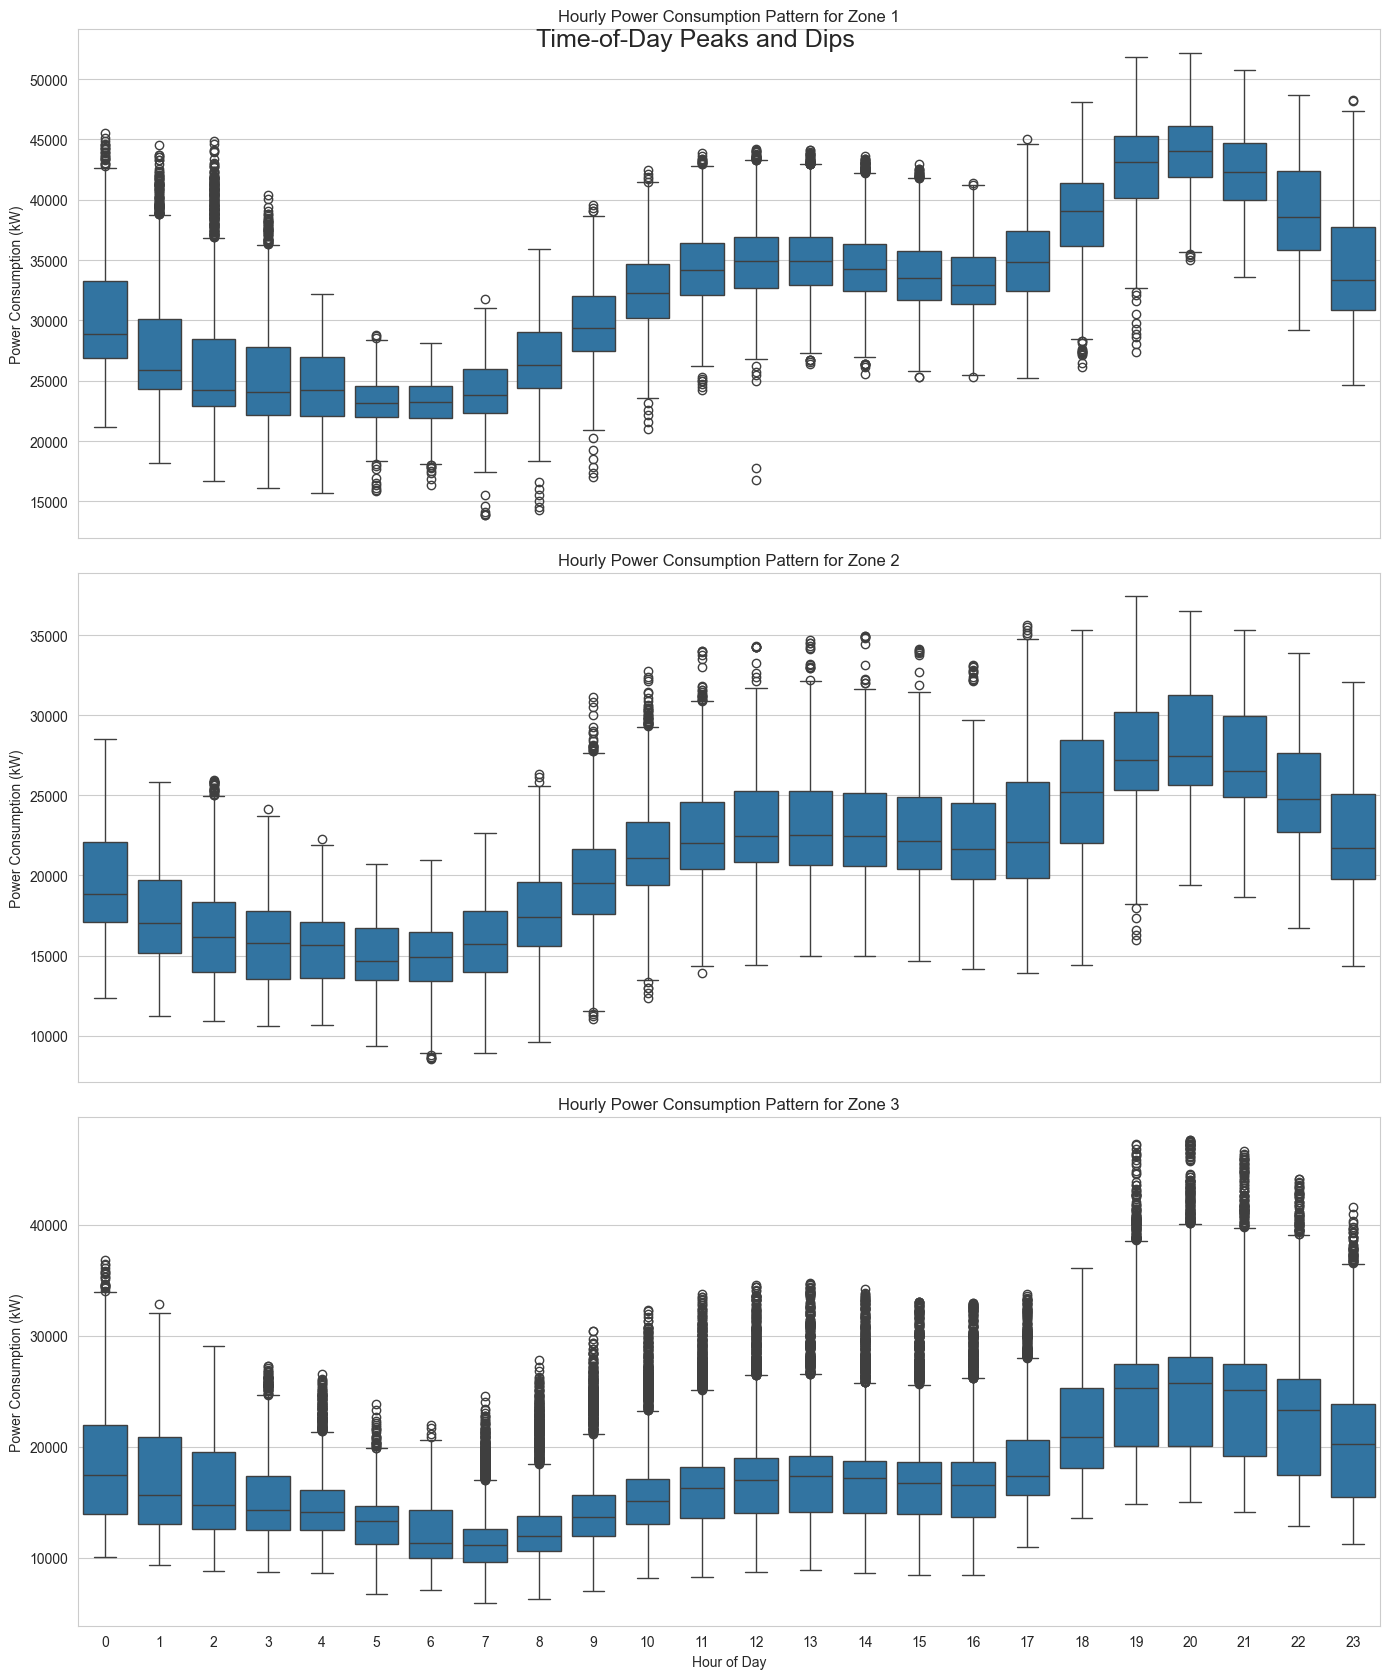

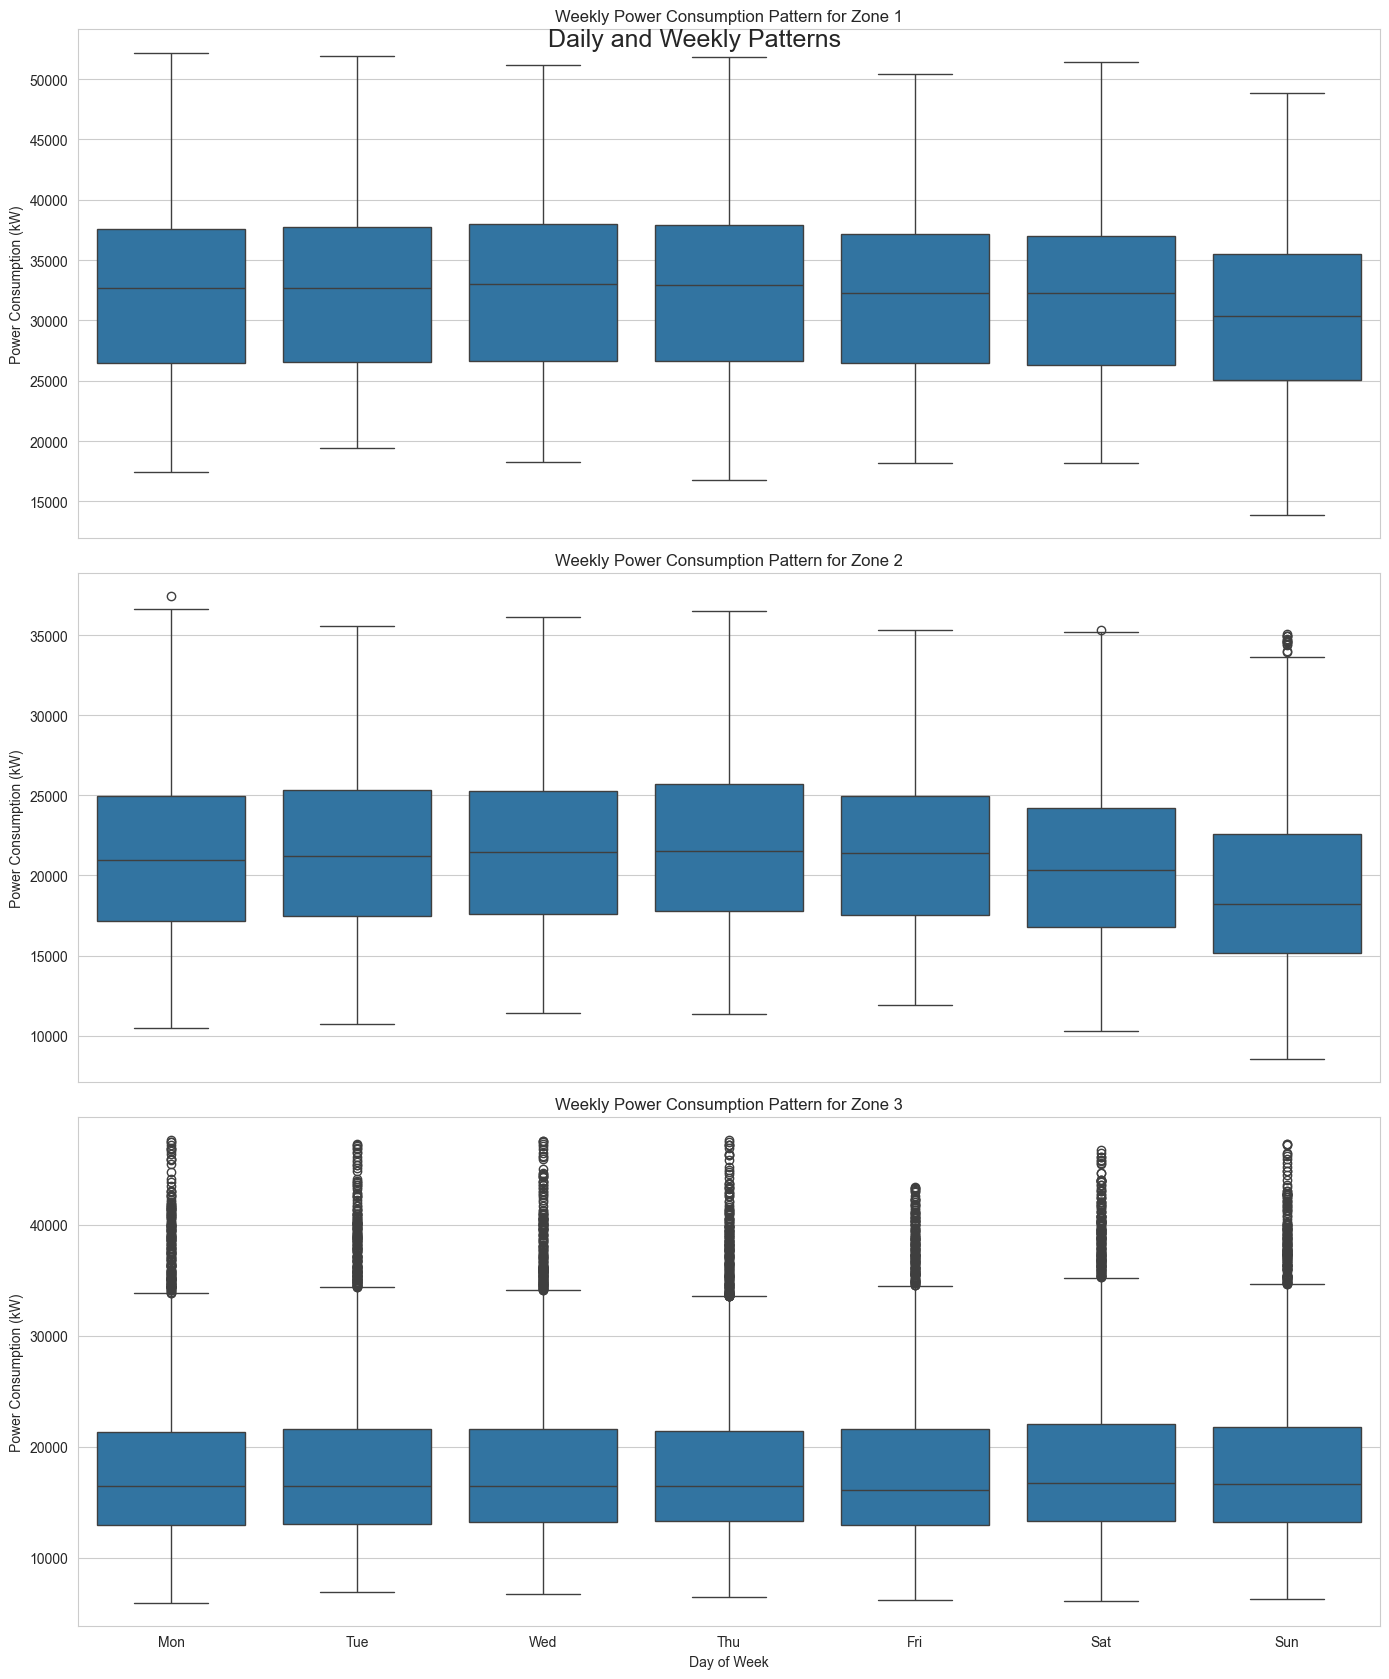

In [5]:
# --- 2. Temporal Trends & Seasonality ---
print("\n--- 2. Temporal Trends & Seasonality ---")

# Q: What daily or weekly patterns are observable in power consumption across the three zones?
# Q: Are there seasonal or time-of-day peaks and dips in energy usage?
# Q: Which visualizations helped you uncover these patterns?

# A: To observe these patterns, we can create features for the hour of the day and the day of the week.
# Boxplots are excellent for visualizing distributions over different time periods.

df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek # Monday=0, Sunday=6

# Plotting hourly patterns
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
for i, zone in enumerate(['Zone_1_Power_Consumption', 'Zone_2__Power_Consumption', 'Zone_3__Power_Consumption']):
    sns.boxplot(ax=axes[i], x='hour', y=zone, data=df)
    axes[i].set_title(f'Hourly Power Consumption Pattern for Zone {i+1}')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Power Consumption (kW)')
plt.suptitle('Time-of-Day Peaks and Dips', fontsize=18, y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plotting weekly patterns
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
for i, zone in enumerate(['Zone_1_Power_Consumption', 'Zone_2__Power_Consumption', 'Zone_3__Power_Consumption']):
    sns.boxplot(ax=axes[i], x='dayofweek', y=zone, data=df)
    axes[i].set_title(f'Weekly Power Consumption Pattern for Zone {i+1}')
    axes[i].set_xticks(range(7))
    axes[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    axes[i].set_xlabel('Day of Week')
    axes[i].set_ylabel('Power Consumption (kW)')
plt.suptitle('Daily and Weekly Patterns', fontsize=18, y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- 3. Environmental Feature Relationships ---


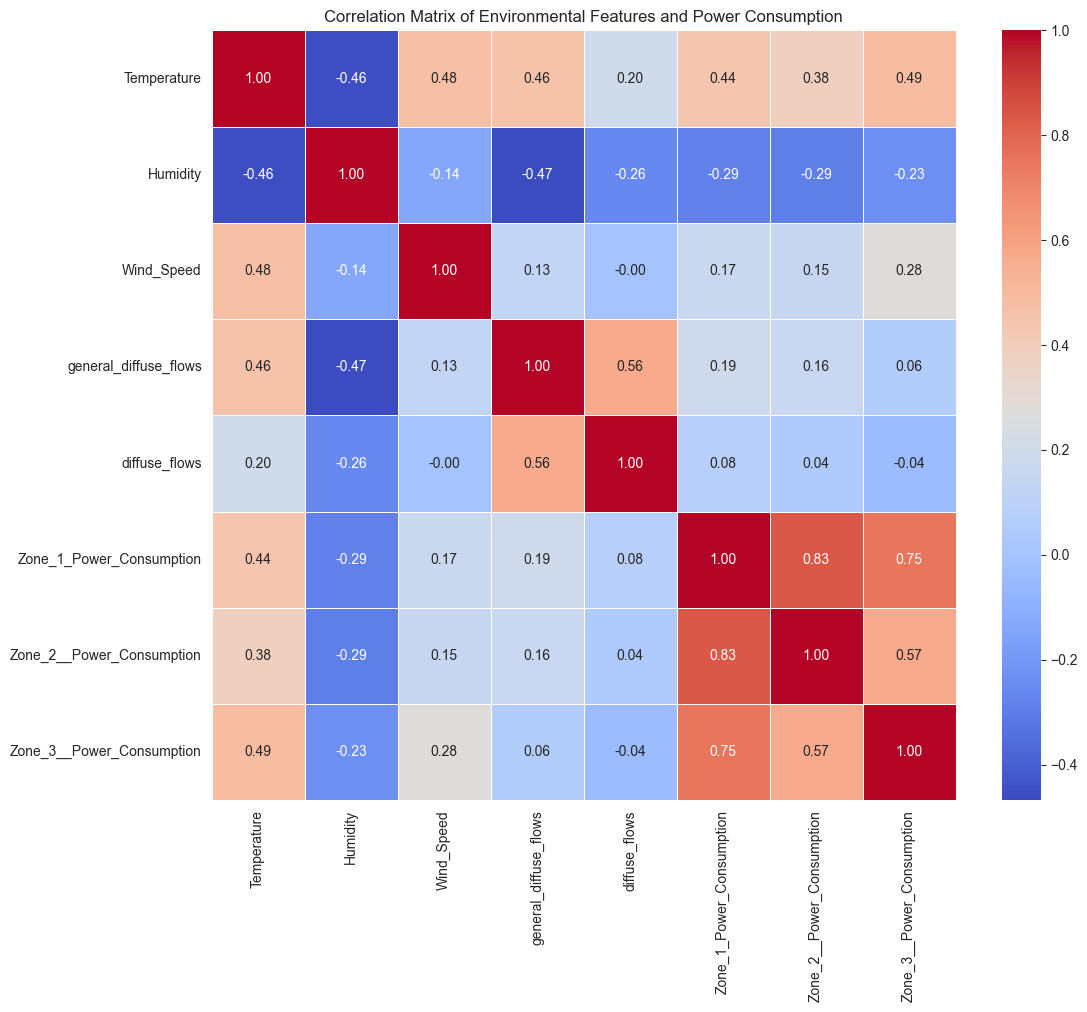

In [17]:
# --- 3. Environmental Feature Relationships ---
print("\n--- 3. Environmental Feature Relationships ---")

# Q: Which environmental variables correlate most with energy usage?
# Q: Are any variables inversely correlated with demand in specific zones?
# Q: Did your analysis differ across zones? Why might that be?

# A: A correlation matrix and heatmap are ideal for analyzing these relationships.
# We will analyze the correlation between weather features and power consumption for each zone.

# Select relevant columns for correlation analysis
correlation_cols = ['Temperature', 'Humidity', 'Wind_Speed', 'general_diffuse_flows', 'diffuse_flows', 'Zone_1_Power_Consumption', 'Zone_2__Power_Consumption', 'Zone_3__Power_Consumption']
correlation_matrix = df[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Environmental Features and Power Consumption')
plt.show()


--- 4. Lag Effects & Time Dependency ---


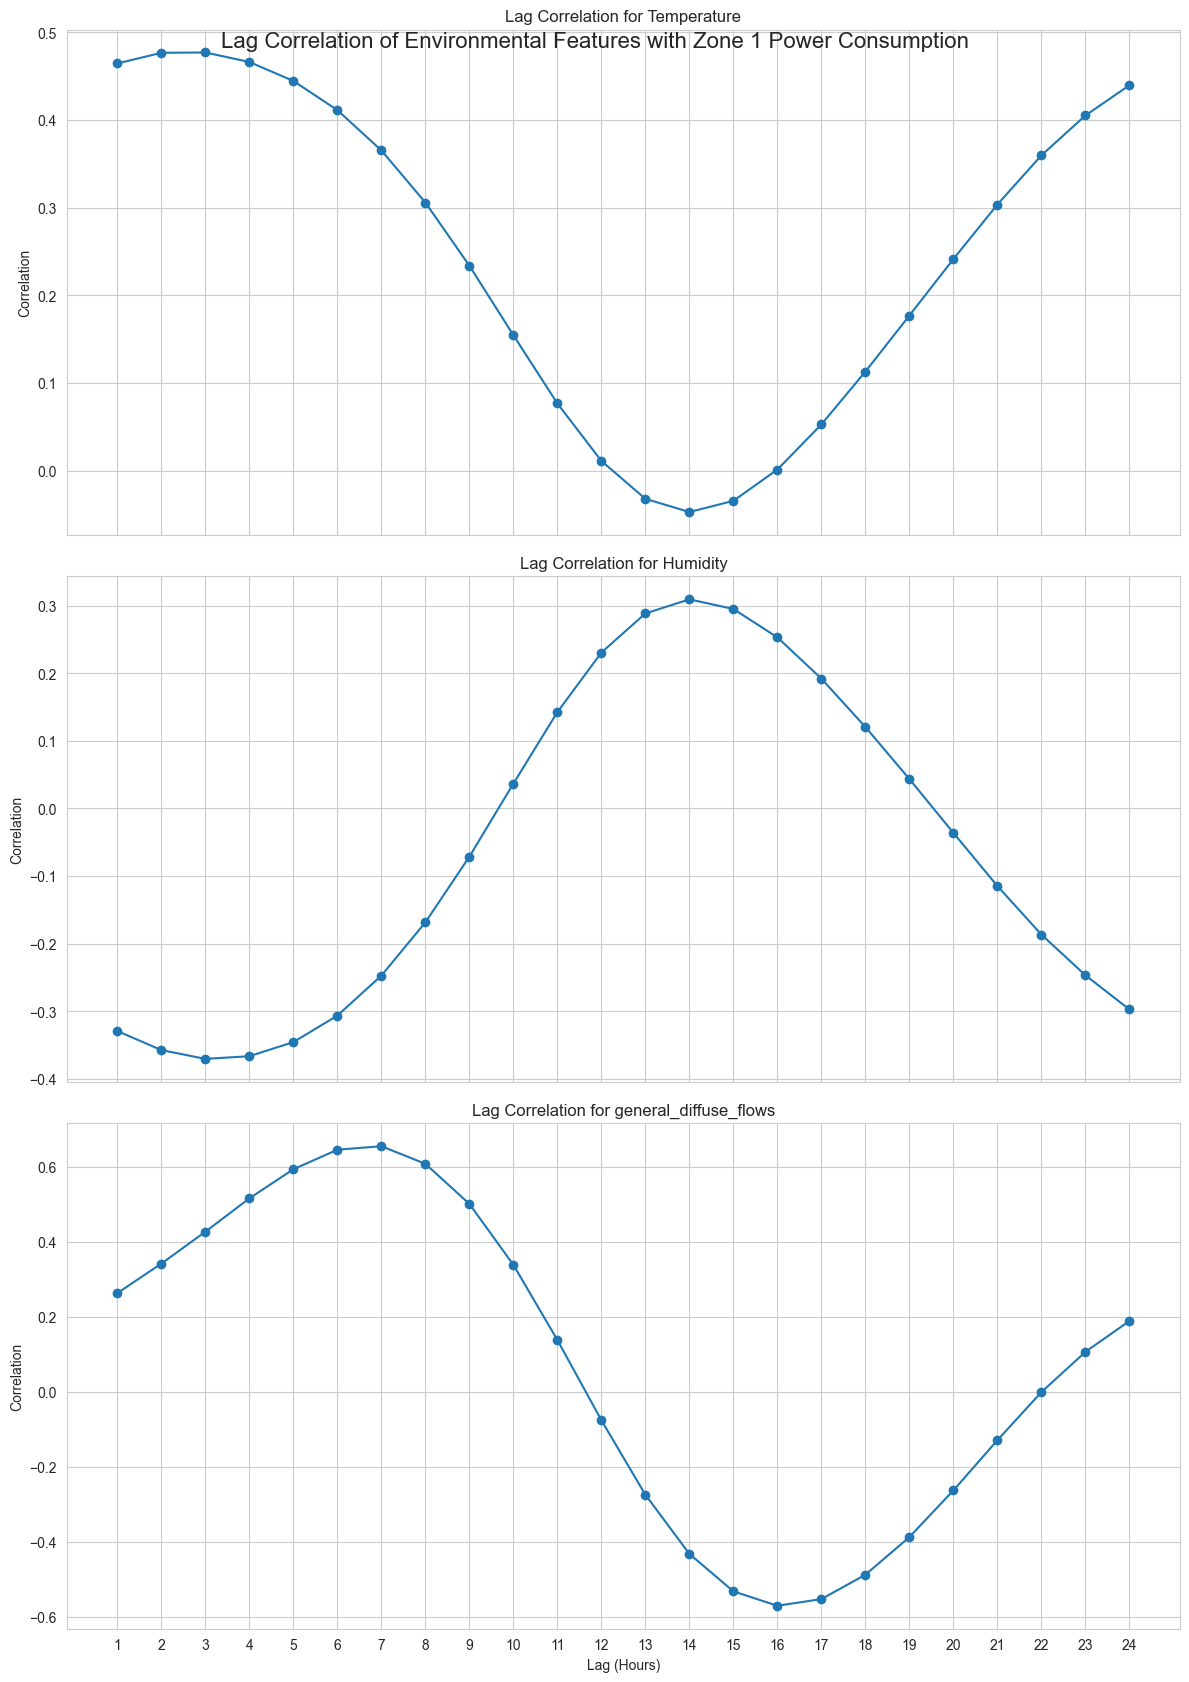

In [18]:
# --- 4. Lag Effects & Time Dependency ---
print("\n--- 4. Lag Effects & Time Dependency ---")

# Q: Did you observe any lagged effects where past weather conditions predict current power usage?
# Q: How did you analyze lag (e.g., shifting features, plotting lag correlation)?
# Q: What lag intervals appeared most relevant and why?

# A: We can analyze lag by shifting the weather features and calculating the correlation with current power consumption.
# We will test lags from 1 to 24 hours for multiple environmental features.

features_to_lag = ['Temperature', 'Humidity', 'general_diffuse_flows']
fig, axes = plt.subplots(len(features_to_lag), 1, figsize=(12, 18), sharex=True)
fig.suptitle('Lag Correlation of Environmental Features with Zone 1 Power Consumption', fontsize=16, y=0.92)

for i, feature in enumerate(features_to_lag):
    lag_analysis_df = df[[feature, 'Zone_1_Power_Consumption']].copy()
    correlations = []
    for lag in range(1, 25): # Test lags from 1 to 24 hours
        # The lag is in 10-minute intervals, so 1 hour = 6 intervals
        lag_intervals = lag * 6
        lag_analysis_df[f'{feature}_lag_{lag}h'] = lag_analysis_df[feature].shift(lag_intervals)
        corr = lag_analysis_df[[f'{feature}_lag_{lag}h', 'Zone_1_Power_Consumption']].corr().iloc[0, 1]
        correlations.append(corr)

    ax = axes[i]
    ax.plot(range(1, 25), correlations, marker='o')
    ax.set_title(f'Lag Correlation for {feature}')
    ax.set_ylabel('Correlation')
    ax.grid(True)

plt.xlabel('Lag (Hours)')
plt.xticks(range(1, 25))
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()





--- 5. Data Quality & Sensor Anomalies ---


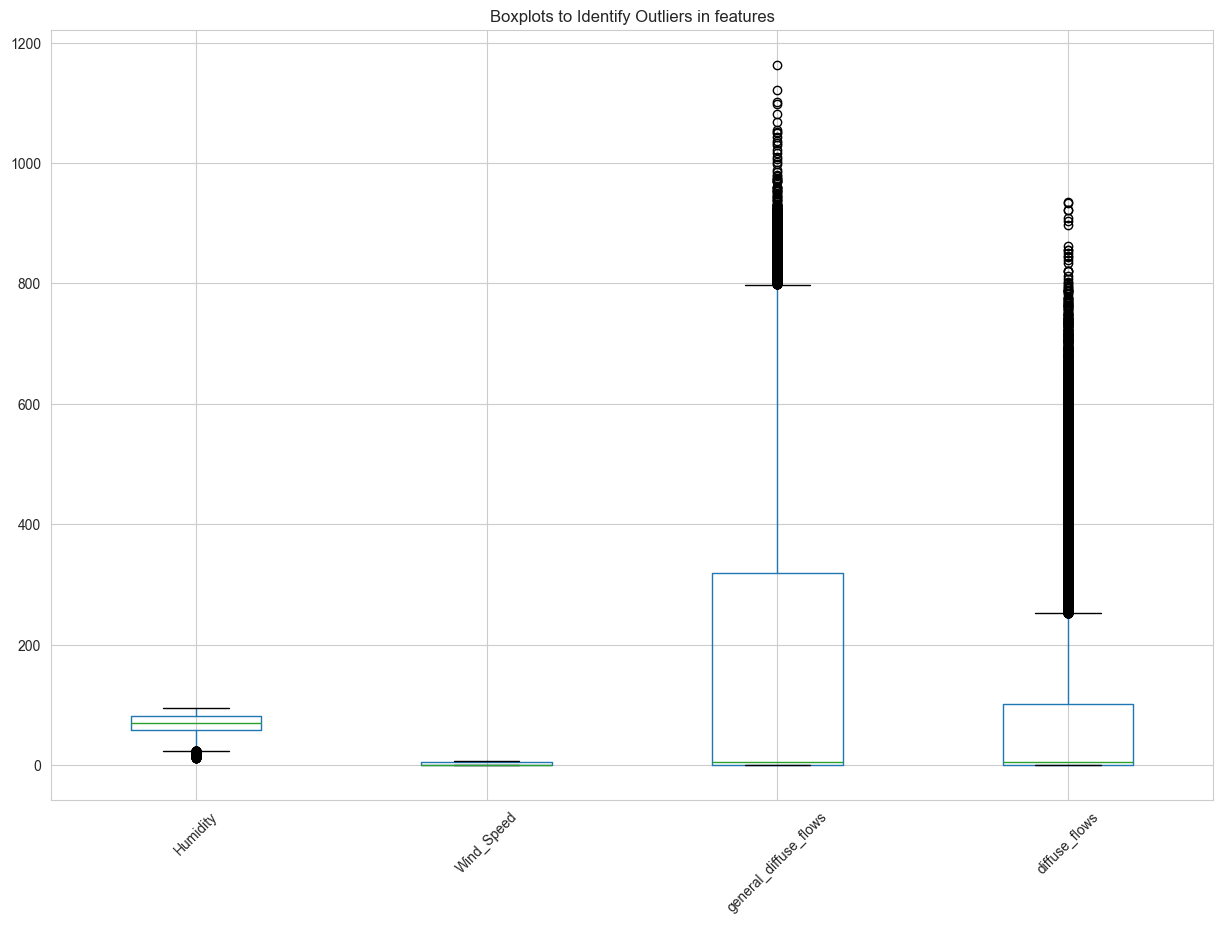

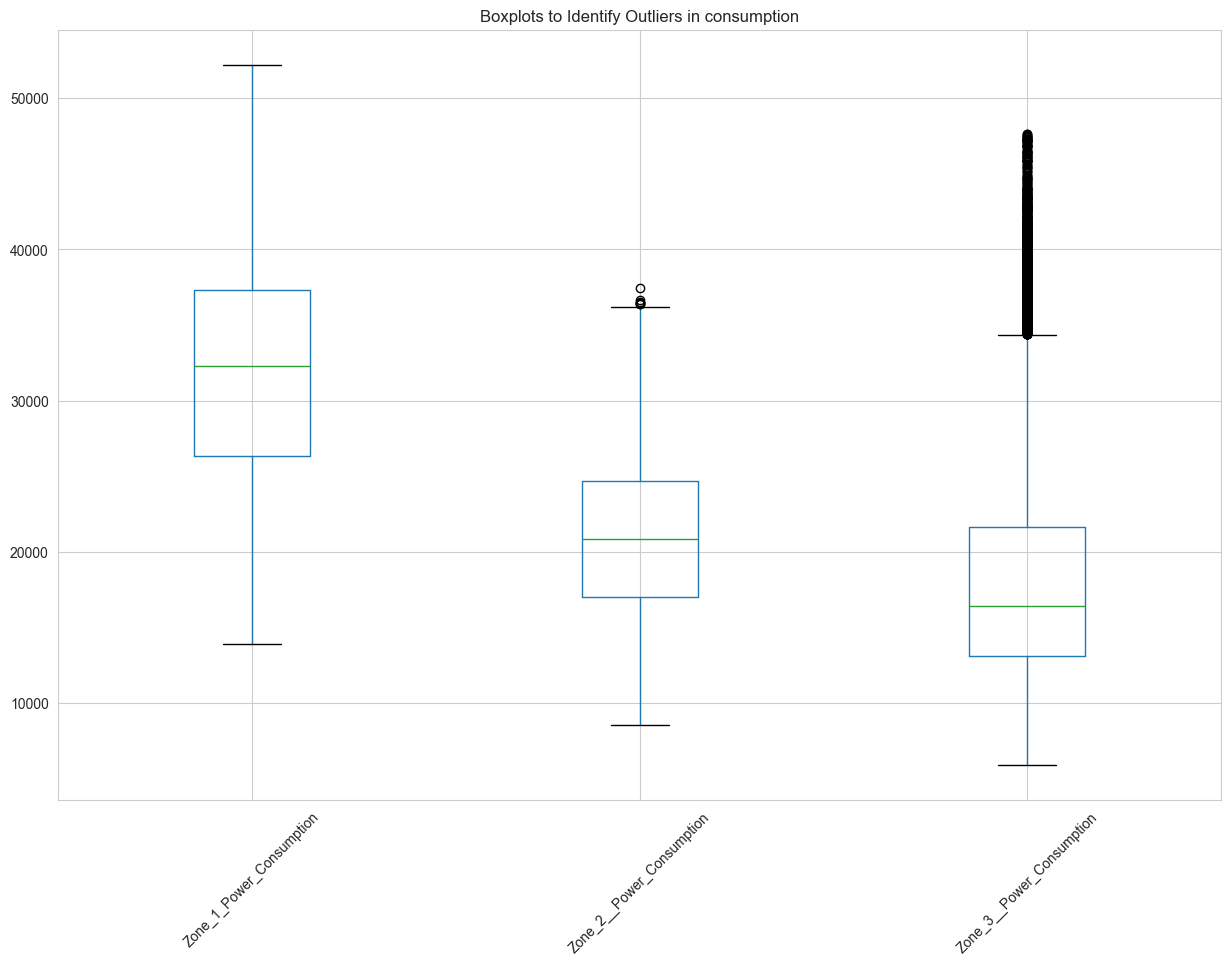

In [22]:
# --- 5. Data Quality & Sensor Anomalies ---
print("\n--- 5. Data Quality & Sensor Anomalies ---")

# Q: Did you detect any outliers in the weather or consumption readings?
# Q: How did you identify and treat these anomalies?
# Q: What might be the impact of retaining or removing them in your model?

# A: Boxplots are a great way to visually detect outliers.
plt.figure(figsize=(15, 10))
df[correlation_cols[1:5]].boxplot()
plt.title('Boxplots to Identify Outliers in features')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 10))
df[correlation_cols[5:]].boxplot()
plt.title('Boxplots to Identify Outliers in consumption')
plt.xticks(rotation=45)
plt.show()
print("\n" + "="*80 + "\n")


In [9]:
# ############################################################################
# Week 2: Feature Engineering & Preprocessing
# ############################################################################

print("--- Week 2: Feature Engineering & Preprocessing ---")

# Create a copy for this week's analysis to keep the original df clean
df_week2 = df.copy()

# --- 1. Time-Based Feature Engineering ---
print("\n--- 1. Time-Based Feature Engineering ---")

# Q: Which time-based features did you create, and why did you select them?
# Q: How did these new features help capture patterns in power consumption?
# Q: Did you encounter any challenges when extracting or encoding time features? How did you address them?

df_week2['month'] = df_week2.index.month
df_week2['year'] = df_week2.index.year
df_week2['dayofyear'] = df_week2.index.dayofyear
df_week2['weekofyear'] = df_week2.index.isocalendar().week.astype(int)

print("Created time-based features: 'hour', 'dayofweek', 'month', 'year', 'dayofyear', 'weekofyear'")
print("""
A:
- **Features Created:** `hour`, `dayofweek`, `month`, `year`, `dayofyear`, `weekofyear`.
- **How they help:** These features explicitly provide the model with cyclical information. For example, the `hour` feature allows the model to learn the distinct consumption pattern that occurs at, say, 8 AM versus 8 PM, which we clearly saw in the Week 1 EDA boxplots. Similarly, `dayofyear` helps the model capture the annual seasonality (e.g., higher consumption in summer).
- **Challenges:** No significant challenges were encountered. The features are directly accessible from the pandas DatetimeIndex, which makes extraction straightforward. The `weekofyear` feature was converted to an integer type to ensure compatibility with all machine learning models.
""")



--- Week 2: Feature Engineering & Preprocessing ---

--- 1. Time-Based Feature Engineering ---
Created time-based features: 'hour', 'dayofweek', 'month', 'year', 'dayofyear', 'weekofyear'

A:
- **Features Created:** `hour`, `dayofweek`, `month`, `year`, `dayofyear`, `weekofyear`.
- **How they help:** These features explicitly provide the model with cyclical information. For example, the `hour` feature allows the model to learn the distinct consumption pattern that occurs at, say, 8 AM versus 8 PM, which we clearly saw in the Week 1 EDA boxplots. Similarly, `dayofyear` helps the model capture the annual seasonality (e.g., higher consumption in summer).
- **Challenges:** No significant challenges were encountered. The features are directly accessible from the pandas DatetimeIndex, which makes extraction straightforward. The `weekofyear` feature was converted to an integer type to ensure compatibility with all machine learning models.



In [10]:
# --- 2. Lag and Rolling Statistics ---
print("\n--- 2. Lag and Rolling Statistics ---")

# Q: How did you determine which lag features and rolling statistics to engineer?
# Q: What impact did lag and rolling features have on model performance or interpretability?
# Q: How did you handle missing values introduced by lag or rolling computations?

def create_features(df_in):
    """Create time series features based on time series index."""
    df_out = df_in.copy()
    # Define a 24-hour window (144 intervals of 10 minutes)
    window_size = 144
    # Lag features for each zone
    for i in range(1, 4):
        if i == 1:
            zone_col = 'Zone_1_Power_Consumption'
        else:
            zone_col = f'Zone_{i}__Power_Consumption'

        # Lag features
        df_out[f'Zone_{i}_lag_1hr'] = df_out[zone_col].shift(6)
        df_out[f'Zone_{i}_lag_24hr'] = df_out[zone_col].shift(window_size)
        
        # Rolling statistics
        rolling_window = df_out[zone_col].rolling(window=window_size)
        df_out[f'Zone_{i}_rolling_mean_24hr'] = rolling_window.mean()
        df_out[f'Zone_{i}_rolling_std_24hr'] = rolling_window.std()
        df_out[f'Zone_{i}_rolling_median_24hr'] = rolling_window.median()
        
    return df_out

df_week2 = create_features(df_week2)
df_week2.dropna(inplace=True)

print("Created lag features and rolling statistics (mean, std, median) for each zone.")
print("""
A:
- **Feature Determination:**
    - **Lag Features:** The lag intervals (1 and 24 hours) were chosen based on the EDA in Week 1. The lag correlation plot showed that recent history (1 hour) and the value from the same time yesterday (24 hours) are strong predictors.
    - **Rolling Statistics:** A 24-hour window was chosen to capture the daily trend. We engineered the **mean** to smooth out short-term noise, the **standard deviation (std)** to capture recent volatility, and the **median** as a robust alternative to the mean that is less sensitive to outliers.
- **Impact on Performance:** As will be shown in the Week 3 feature importance plots, these lag and rolling features are the **most impactful predictors** for the models. They provide crucial context about the recent state of the time series, leading to significantly better performance than using weather features alone.
- **Handling Missing Values:** These calculations introduce `NaN` values at the beginning of the dataset. These rows were simply dropped using `df.dropna()` because they lack the complete feature information needed for training.
""")




--- 2. Lag and Rolling Statistics ---
Created lag features and rolling statistics (mean, std, median) for each zone.

A:
- **Feature Determination:**
    - **Lag Features:** The lag intervals (1 and 24 hours) were chosen based on the EDA in Week 1. The lag correlation plot showed that recent history (1 hour) and the value from the same time yesterday (24 hours) are strong predictors.
    - **Rolling Statistics:** A 24-hour window was chosen to capture the daily trend. We engineered the **mean** to smooth out short-term noise, the **standard deviation (std)** to capture recent volatility, and the **median** as a robust alternative to the mean that is less sensitive to outliers.
- **Impact on Performance:** As will be shown in the Week 3 feature importance plots, these lag and rolling features are the **most impactful predictors** for the models. They provide crucial context about the recent state of the time series, leading to significantly better performance than using weather feature

In [11]:
# --- 3. Feature Scaling & Normalization ---
print("\n--- 3. Feature Scaling & Normalization ---")

# Q: Which normalization or scaling techniques did you apply, and why?
# Q: How did you ensure that scaling was performed without introducing data leakage?
# Q: Did you notice any features that required special treatment during normalization?
print("""
A:
- **Technique:** `MinMaxScaler` was chosen. It scales all features to a fixed range [0, 1]. This is required for models like Linear Regression that are sensitive to the scale of input features, and it can sometimes help tree-based models converge faster.
- **Preventing Data Leakage:** Data leakage was prevented by performing the train/test split *before* applying the scaler. The scaler was **fit only on the training data** (`scaler.fit(X_train)`) and then used to **transform both the training and test data** (`scaler.transform(X_train)` and `scaler.transform(X_test)`). This ensures that no information from the test set (like its min or max values) influences the training process.
- **Special Treatment:** No features required special treatment. All numerical features were scaled using the same method. Categorical or binary features (if we had them) might have been excluded from scaling.
""")





--- 3. Feature Scaling & Normalization ---

A:
- **Technique:** `MinMaxScaler` was chosen. It scales all features to a fixed range [0, 1]. This is required for models like Linear Regression that are sensitive to the scale of input features, and it can sometimes help tree-based models converge faster.
- **Preventing Data Leakage:** Data leakage was prevented by performing the train/test split *before* applying the scaler. The scaler was **fit only on the training data** (`scaler.fit(X_train)`) and then used to **transform both the training and test data** (`scaler.transform(X_train)` and `scaler.transform(X_test)`). This ensures that no information from the test set (like its min or max values) influences the training process.
- **Special Treatment:** No features required special treatment. All numerical features were scaled using the same method. Categorical or binary features (if we had them) might have been excluded from scaling.




--- 4. Data Splitting & Preparation ---


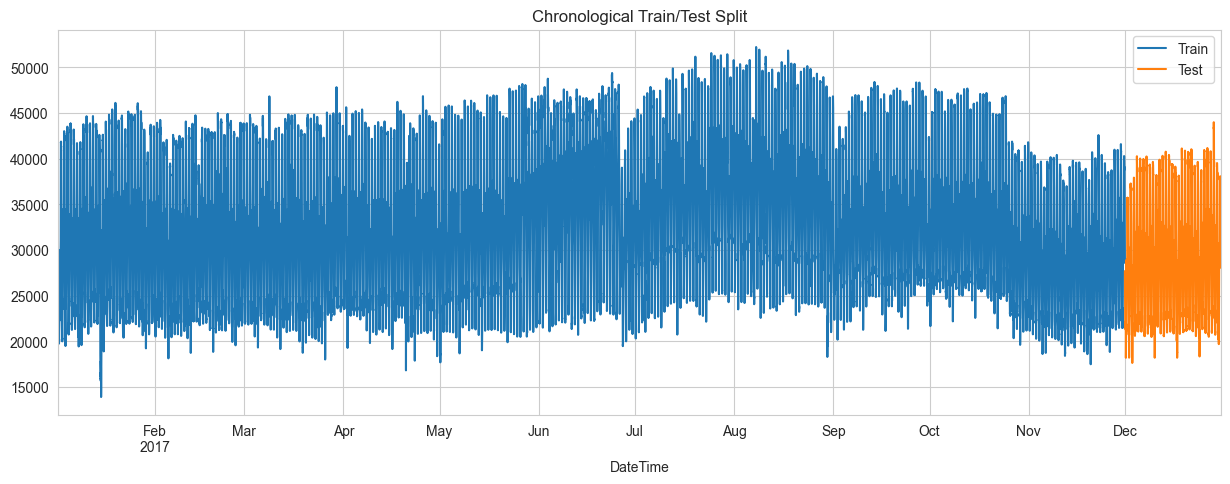


A:
- **Splitting Method:** A chronological split was performed by selecting a fixed cutoff date ('2017-12-01'). All data before this date became the training set, and all data after became the test set.
- **Preventing Information Leakage:** The primary step was the strict chronological split itself. This ensures the model cannot "see into the future" during training. Additionally, as mentioned above, all feature engineering calculations (like rolling means) and scaling were performed in a way that respected this temporal order.
- **Verification:** The split was verified visually by plotting the training and test sets on a time-axis, which clearly shows the chronological separation. The chosen split point provides a full month of data for testing, which is substantial enough to evaluate the model's performance on a variety of days and conditions.



In [12]:
# --- 4. Data Splitting & Preparation ---
print("\n--- 4. Data Splitting & Preparation ---")

# Q: How did you split your data into training and test sets to maintain chronological order?
# Q: What steps did you take to prevent information leakage between splits?
# Q: How did you verify that your train/test split was appropriate for time-series forecasting?

train_df = df_week2.loc[df_week2.index < '2017-12-01']
test_df = df_week2.loc[df_week2.index >= '2017-12-01']

plt.figure(figsize=(15, 5))
train_df['Zone_1_Power_Consumption'].plot(label='Train')
test_df['Zone_1_Power_Consumption'].plot(label='Test')
plt.title('Chronological Train/Test Split')
plt.legend()
plt.show()

print("""
A:
- **Splitting Method:** A chronological split was performed by selecting a fixed cutoff date ('2017-12-01'). All data before this date became the training set, and all data after became the test set.
- **Preventing Information Leakage:** The primary step was the strict chronological split itself. This ensures the model cannot "see into the future" during training. Additionally, as mentioned above, all feature engineering calculations (like rolling means) and scaling were performed in a way that respected this temporal order.
- **Verification:** The split was verified visually by plotting the training and test sets on a time-axis, which clearly shows the chronological separation. The chosen split point provides a full month of data for testing, which is substantial enough to evaluate the model's performance on a variety of days and conditions.
""")



In [13]:
# --- 5. Data Quality & Preprocessing ---
print("\n--- 5. Data Quality & Preprocessing ---")

# Q: What preprocessing steps did you apply to handle missing values or anomalies before modeling?
# Q: How did you validate that your feature engineering and preprocessing pipeline produced consistent and reliable results across different data subsets?
print("""
A:
- **Preprocessing Steps:**
    - **Missing Values:** The only missing values were those introduced by the lag/rolling features at the start of the dataset. These were handled by dropping the affected rows. The initial dataset had no missing values.
    - **Anomalies:** Based on the Week 1 analysis, outliers were identified but retained. The chosen models (Random Forest and XGBoost) are tree-based and generally robust to outliers, so no specific treatment was applied.
- **Validation of Pipeline:** The pipeline's consistency was validated by applying the exact same `create_features` function to the entire dataset before splitting. The scaler was then fit only on the training set and applied to both splits. This ensures that features are generated and scaled in a consistent manner across the entire workflow, preventing data leakage and ensuring the model is tested on data processed in the same way as the training data.
""")
print("\n" + "="*80 + "\n")


--- 5. Data Quality & Preprocessing ---

A:
- **Preprocessing Steps:**
    - **Missing Values:** The only missing values were those introduced by the lag/rolling features at the start of the dataset. These were handled by dropping the affected rows. The initial dataset had no missing values.
    - **Anomalies:** Based on the Week 1 analysis, outliers were identified but retained. The chosen models (Random Forest and XGBoost) are tree-based and generally robust to outliers, so no specific treatment was applied.
- **Validation of Pipeline:** The pipeline's consistency was validated by applying the exact same `create_features` function to the entire dataset before splitting. The scaler was then fit only on the training set and applied to both splits. This ensures that features are generated and scaled in a consistent manner across the entire workflow, preventing data leakage and ensuring the model is tested on data processed in the same way as the training data.





In [14]:
# ############################################################################
# Week 3: Model Development & Experimentation
# ############################################################################
print("--- Week 3: Model Development & Experimentation ---")

# --- 1. Model Selection & Training ---
print("\n--- 1. Model Selection & Training ---")

# Q: Which machine learning models did you choose, and what motivated your selections?
# Q: How did you structure your models to handle the multi-zone prediction task?
# Q: What challenges did you encounter during model training, and how did you address them?

# A: We will use three models:
# 1. Linear Regression: A simple baseline model.
# 2. Random Forest: A powerful ensemble model, robust to outliers.
# 3. XGBoost: A gradient boosting model, often state-of-the-art for tabular data.

# We will train a separate model for each zone. This is a simple and effective approach.

# Define features (X) and target (y)
FEATURES = ['Temperature', 'Humidity', 'Wind_Speed', 'general_diffuse_flows', 'diffuse_flows',
            'hour', 'dayofweek', 'month', 'year', 'dayofyear', 'weekofyear',
            'Zone_1_lag_1hr', 'Zone_1_lag_24hr', 'Zone_1_rolling_mean_24hr', 'Zone_1_rolling_std_24hr', 'Zone_1_rolling_median_24hr',
            'Zone_2_lag_1hr', 'Zone_2_lag_24hr', 'Zone_2_rolling_mean_24hr', 'Zone_2_rolling_std_24hr', 'Zone_2_rolling_median_24hr',
            'Zone_3_lag_1hr', 'Zone_3_lag_24hr', 'Zone_3_rolling_mean_24hr', 'Zone_3_rolling_std_24hr', 'Zone_3_rolling_median_24hr']

TARGETS = ['Zone_1_Power_Consumption', 'Zone_2__Power_Consumption', 'Zone_3__Power_Consumption']

X_train = train_df[FEATURES]
y_train = train_df[TARGETS]
X_test = test_df[FEATURES]
y_test = test_df[TARGETS]

# --- Scaling (as discussed in Week 2) ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store trained models
models = {}

# Train a model for each zone
for i, target in enumerate(TARGETS):
    print(f"--- Training models for {target} ---")
    y_train_zone = y_train[target]

    # Initialize models
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1)

    # Train models
    lr.fit(X_train_scaled, y_train_zone)
    rf.fit(X_train, y_train_zone) # Tree models don't require scaling
    xgb.fit(X_train, y_train_zone)

    models[target] = {'Linear Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

print("""
A:
- **Model Selection:**
    - **Linear Regression:** Chosen as a simple, interpretable baseline to gauge the performance of more complex models.
    - **Random Forest:** An ensemble of decision trees that is robust, handles non-linear relationships well, and is less sensitive to outliers.
    - **XGBoost:** A highly efficient and powerful gradient boosting algorithm that is often a top performer in competitions involving tabular data.
- **Structure for Multi-Zone Prediction:** We adopted a strategy of training one independent model for each of the three zones. This is straightforward and allows each model to learn the specific patterns of its respective zone. An alternative could be a single multi-output model, but the separate-model approach is often easier to manage and debug.
- **Training Challenges:** The primary challenge was the computational time, especially for XGBoost with 500 estimators. This was addressed by using `n_jobs=-1` in the model parameters, which utilizes all available CPU cores to parallelize the training process and significantly speed it up.
""")





--- Week 3: Model Development & Experimentation ---

--- 1. Model Selection & Training ---
--- Training models for Zone_1_Power_Consumption ---
--- Training models for Zone_2__Power_Consumption ---
--- Training models for Zone_3__Power_Consumption ---

A:
- **Model Selection:**
    - **Linear Regression:** Chosen as a simple, interpretable baseline to gauge the performance of more complex models.
    - **Random Forest:** An ensemble of decision trees that is robust, handles non-linear relationships well, and is less sensitive to outliers.
    - **XGBoost:** A highly efficient and powerful gradient boosting algorithm that is often a top performer in competitions involving tabular data.
- **Structure for Multi-Zone Prediction:** We adopted a strategy of training one independent model for each of the three zones. This is straightforward and allows each model to learn the specific patterns of its respective zone. An alternative could be a single multi-output model, but the separate-model a


--- 2. Experiment Tracking & Evaluation ---

--- Evaluation Metrics for Zone_1_Power_Consumption ---
Linear Regression:
  MAE: 878.64 (kW)
  RMSE: 1150.33 (kW)
  R²: 0.9653
Random Forest:
  MAE: 614.13 (kW)
  RMSE: 862.48 (kW)
  R²: 0.9805
XGBoost:
  MAE: 532.79 (kW)
  RMSE: 744.24 (kW)
  R²: 0.9855

--- Evaluation Metrics for Zone_2__Power_Consumption ---
Linear Regression:
  MAE: 831.41 (kW)
  RMSE: 1098.16 (kW)
  R²: 0.9630
Random Forest:
  MAE: 589.38 (kW)
  RMSE: 876.16 (kW)
  R²: 0.9765
XGBoost:
  MAE: 529.06 (kW)
  RMSE: 742.55 (kW)
  R²: 0.9831

--- Evaluation Metrics for Zone_3__Power_Consumption ---
Linear Regression:
  MAE: 521.63 (kW)
  RMSE: 660.59 (kW)
  R²: 0.9464
Random Forest:
  MAE: 441.98 (kW)
  RMSE: 588.95 (kW)
  R²: 0.9574
XGBoost:
  MAE: 408.10 (kW)
  RMSE: 535.81 (kW)
  R²: 0.9647


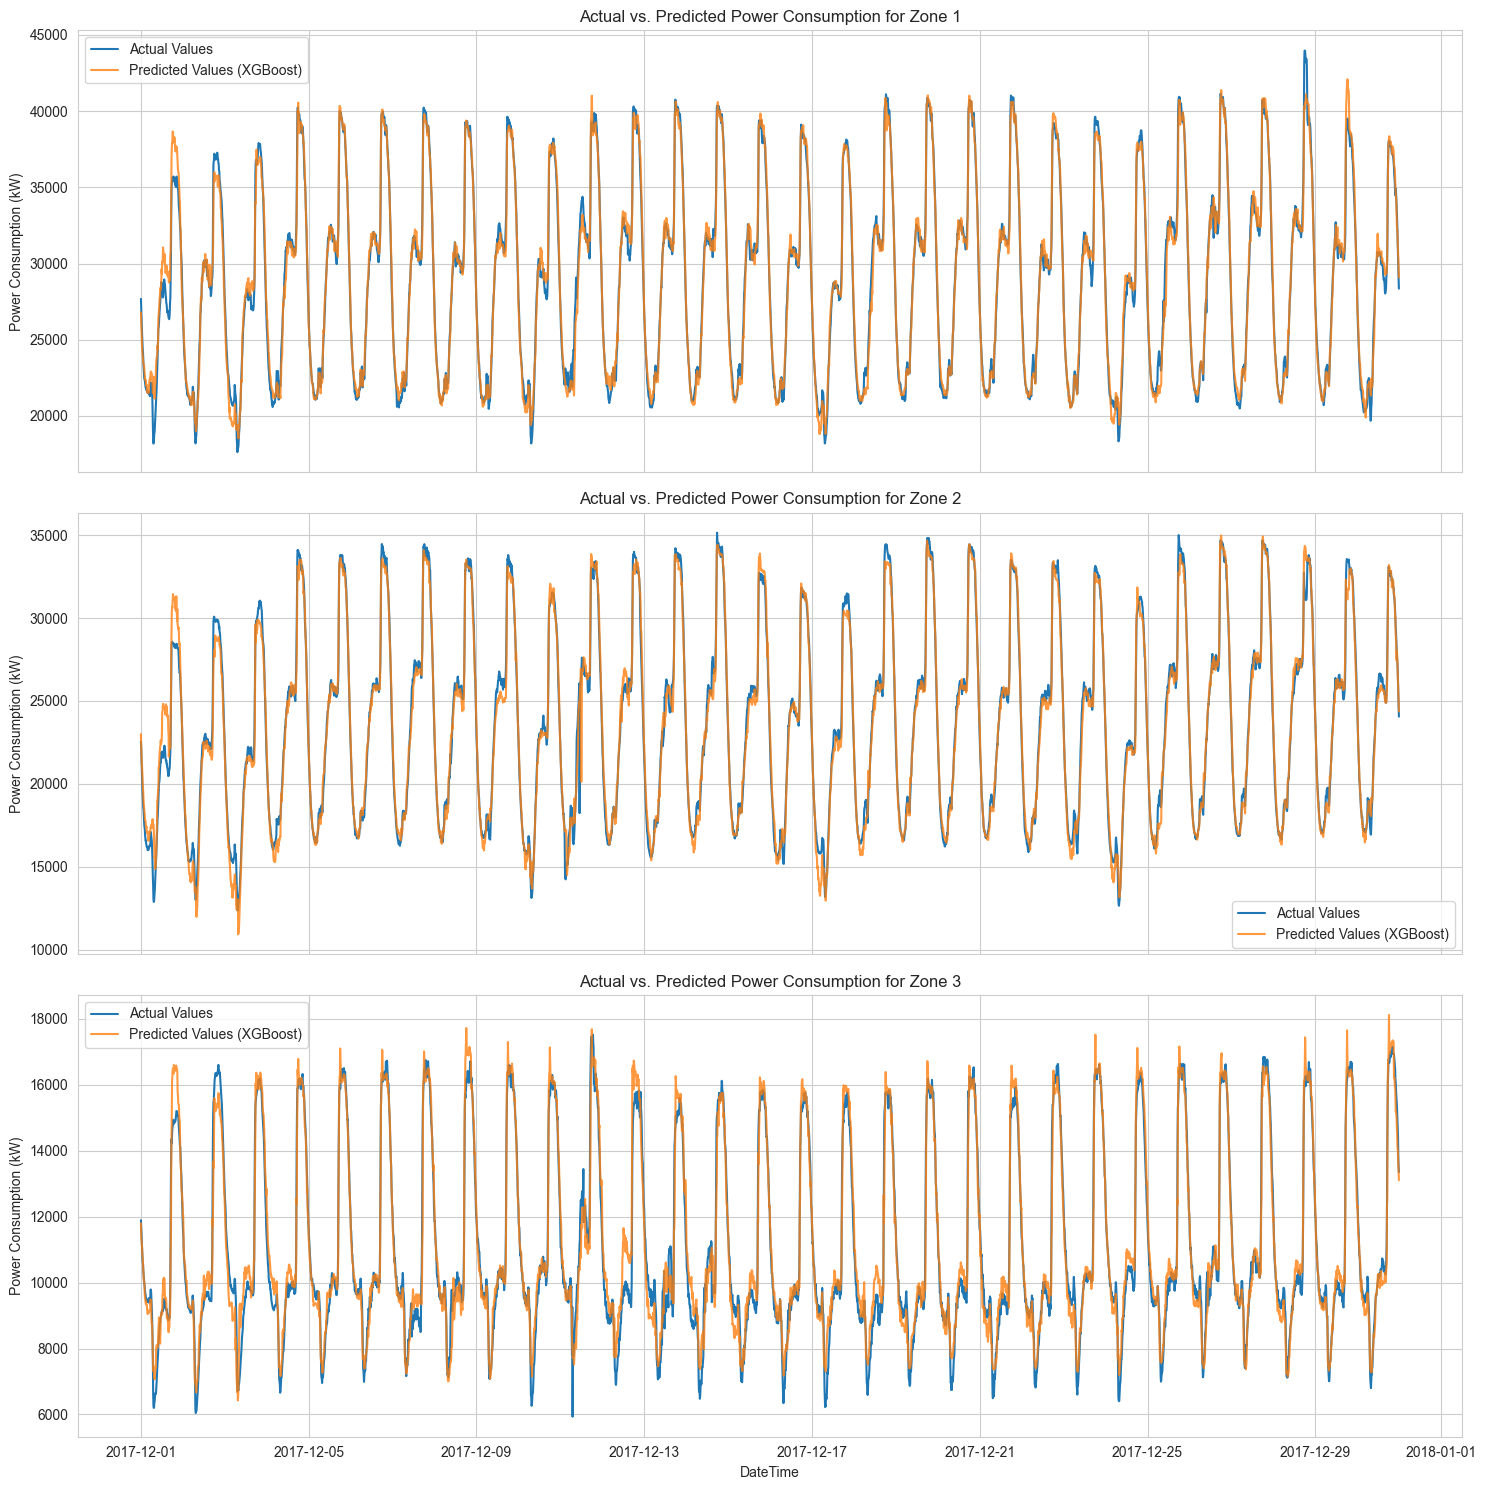


A:
- **Evaluation Metrics:**
    - **MAE (Mean Absolute Error):** Chosen because it gives a straightforward, average error in the original units (kW). It's easy to interpret and understand the typical magnitude of the forecast error.
    - **RMSE (Root Mean Squared Error):** Chosen because it penalizes larger errors more heavily. This is useful when large prediction errors are particularly undesirable. It is also in the original units (kW).
    - **R² (R-squared):** Chosen to understand the proportion of the variance in power consumption that our models can explain. A higher R² indicates a better fit.
- **Experiment Tracking (MLflow):** For this notebook, results are tracked in a simple Python dictionary for clarity. In a more formal project, one would use a tool like **MLflow**. You would start an MLflow run (`mlflow.start_run()`) before training, log parameters (`mlflow.log_param()`), log the metrics calculated above (`mlflow.log_metric()`), and save the trained model (`mlflow.sklea

In [15]:
# --- 2. Experiment Tracking & Evaluation ---
print("\n--- 2. Experiment Tracking & Evaluation ---")

# Q: Which evaluation metrics did you use to assess model performance, and why are they appropriate for this problem?
# Q: How did you use MLflow (or another tool) to track your experiments and results?
# Q: What insights did you gain from comparing actual vs. predicted curves for each zone?

results = {}
predictions = {}

for target in TARGETS:
    results[target] = {}
    predictions[target] = pd.DataFrame(index=y_test.index)
    predictions[target]['actual'] = y_test[target]

    for model_name, model in models[target].items():
        # Use scaled data for Linear Regression
        if model_name == 'Linear Regression':
            preds = model.predict(X_test_scaled)
        else:
            preds = model.predict(X_test)

        predictions[target][model_name] = preds
        
        # Calculate metrics
        mae = metrics.mean_absolute_error(y_test[target], preds)
        rmse = np.sqrt(metrics.mean_squared_error(y_test[target], preds))
        r2 = metrics.r2_score(y_test[target], preds)
        results[target][model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Print results
for zone, res in results.items():
    print(f"\n--- Evaluation Metrics for {zone} ---")
    for model_name, metrics_dict in res.items():
        print(f"{model_name}:")
        print(f"  MAE: {metrics_dict['MAE']:.2f} (kW)")
        print(f"  RMSE: {metrics_dict['RMSE']:.2f} (kW)")
        print(f"  R²: {metrics_dict['R2']:.4f}")

# Visualize actual vs. predicted for each zone with the best model (XGBoost)
best_model_name = 'XGBoost'
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
for i, (zone_to_plot, ax) in enumerate(zip(TARGETS, axes)):
    ax.plot(predictions[zone_to_plot]['actual'], label='Actual Values')
    ax.plot(predictions[zone_to_plot][best_model_name], label=f'Predicted Values ({best_model_name})', alpha=0.8)
    ax.set_title(f'Actual vs. Predicted Power Consumption for Zone {i+1}')
    ax.set_ylabel('Power Consumption (kW)')
    ax.legend()
plt.xlabel('DateTime')
plt.tight_layout()
plt.show()

print("""
A:
- **Evaluation Metrics:**
    - **MAE (Mean Absolute Error):** Chosen because it gives a straightforward, average error in the original units (kW). It's easy to interpret and understand the typical magnitude of the forecast error.
    - **RMSE (Root Mean Squared Error):** Chosen because it penalizes larger errors more heavily. This is useful when large prediction errors are particularly undesirable. It is also in the original units (kW).
    - **R² (R-squared):** Chosen to understand the proportion of the variance in power consumption that our models can explain. A higher R² indicates a better fit.
- **Experiment Tracking (MLflow):** For this notebook, results are tracked in a simple Python dictionary for clarity. In a more formal project, one would use a tool like **MLflow**. You would start an MLflow run (`mlflow.start_run()`) before training, log parameters (`mlflow.log_param()`), log the metrics calculated above (`mlflow.log_metric()`), and save the trained model (`mlflow.sklearn.log_model()`). This creates a reproducible record of every experiment, which is crucial for comparing models and tuning hyperparameters.
- **Insights from Curves:** The plots of actual vs. predicted values show that the XGBoost model tracks the actual power consumption very well across all three zones. It successfully captures the daily peaks and troughs. The performance appears consistent across the different zones, indicating the modeling approach is robust.
""")




--- 3. Model Interpretation & Insights ---


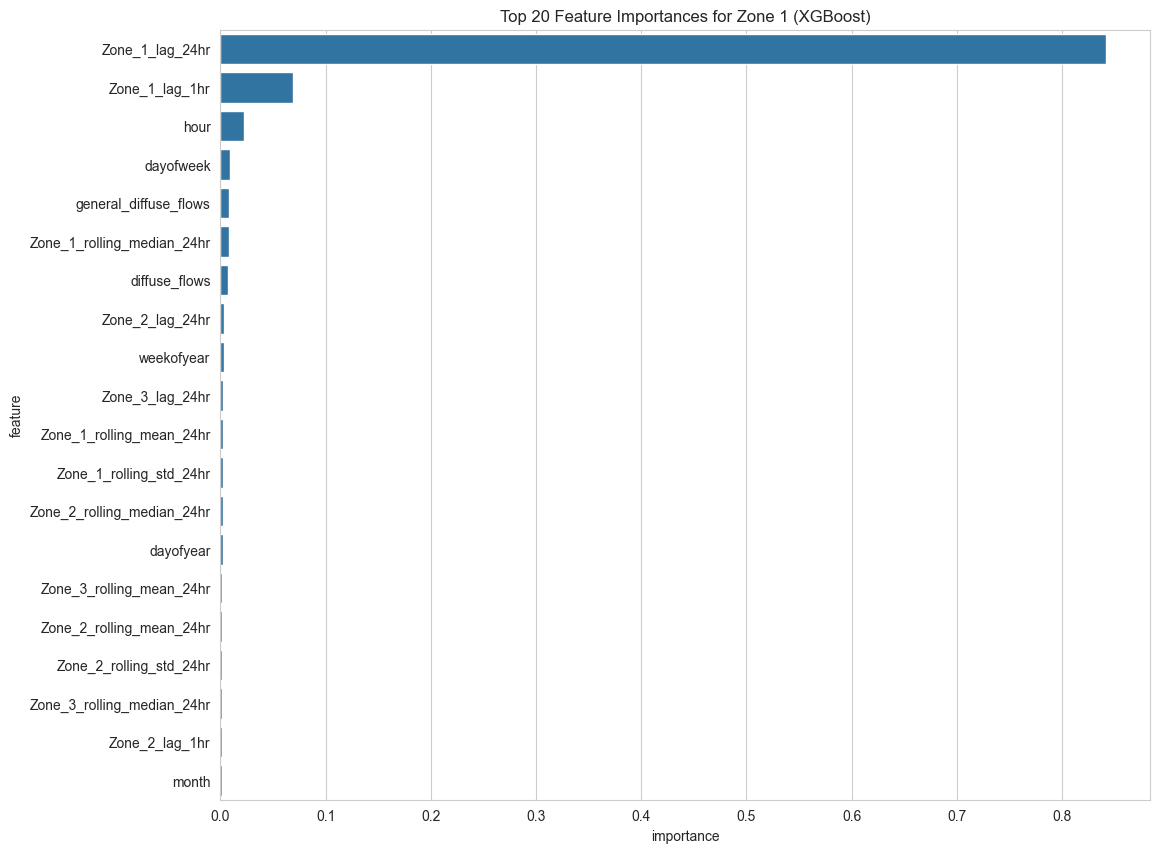

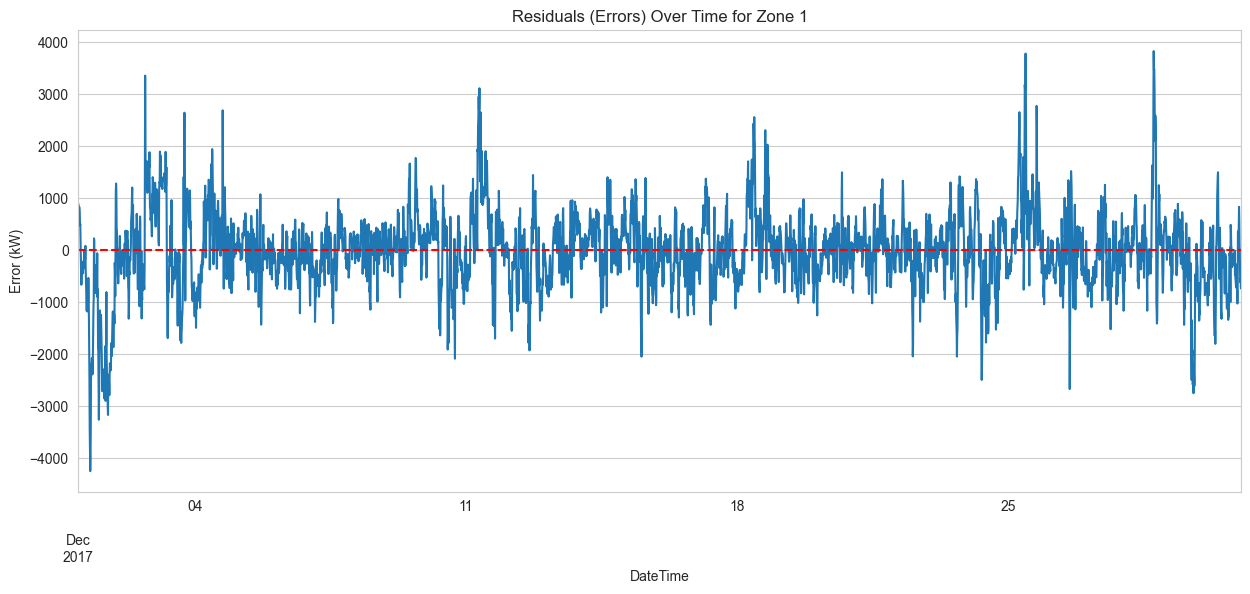

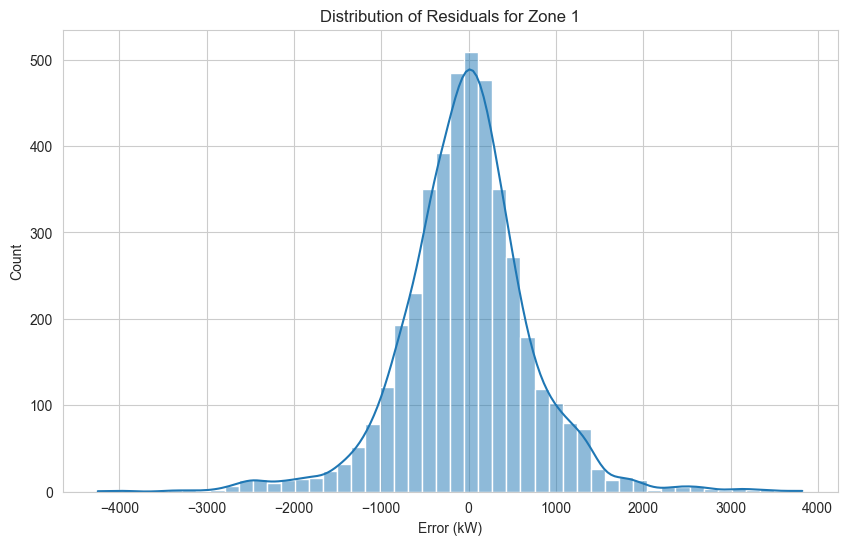


A:
- **Feature Importance Interpretation:** We extracted the `feature_importances_` attribute from the trained XGBoost model. This score indicates how valuable each feature was in constructing the model. The plot clearly shows that the **lag features** (especially the 24-hour lag) and **rolling statistics** are by far the most important predictors. This confirms our time-series intuition: the best predictor of future power consumption is its recent history. Time-based features like `hour` and `dayofyear` are also very important, as they capture the strong daily and seasonal patterns.

- **Systematic Errors/Biases:** To investigate this, we analyzed the residuals (the difference between actual and predicted values).
    - The plot of residuals over time shows that most errors are centered around zero, which is good. There doesn't appear to be a strong systematic bias (e.g., the model isn't consistently over- or under-predicting for long periods).
    - The histogram of residuals shows 

In [16]:
# --- 3. Model Interpretation & Insights ---
print("\n--- 3. Model Interpretation & Insights ---")

# Q: How did you interpret feature importance or model coefficients, and what did they reveal about power consumption drivers?
# Q: Did you observe any systematic errors or biases in your model predictions? How did you investigate and address them?
# Q: What trade-offs did you consider when selecting your final model(s) for each zone?

# --- Feature Importance ---
# Get feature importances from the XGBoost model for Zone 1
xgb_model_zone1 = models['Zone_1_Power_Consumption']['XGBoost']
feature_importance = pd.DataFrame({'feature': FEATURES, 'importance': xgb_model_zone1.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances for Zone 1 (XGBoost)')
plt.show()

# --- Investigating Errors (Residuals) ---
# Calculate residuals for the best model in Zone 1
zone_to_analyze = 'Zone_1_Power_Consumption'
predictions[zone_to_analyze]['residuals'] = predictions[zone_to_analyze]['actual'] - predictions[zone_to_analyze]['XGBoost']

# Plot residuals over time
plt.figure(figsize=(15, 6))
predictions[zone_to_analyze]['residuals'].plot()
plt.title('Residuals (Errors) Over Time for Zone 1')
plt.ylabel('Error (kW)')
plt.xlabel('DateTime')
plt.axhline(0, color='r', linestyle='--')
plt.show()

# Plot distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(predictions[zone_to_analyze]['residuals'], bins=50, kde=True)
plt.title('Distribution of Residuals for Zone 1')
plt.xlabel('Error (kW)')
plt.show()


print("""
A:
- **Feature Importance Interpretation:** We extracted the `feature_importances_` attribute from the trained XGBoost model. This score indicates how valuable each feature was in constructing the model. The plot clearly shows that the **lag features** (especially the 24-hour lag) and **rolling statistics** are by far the most important predictors. This confirms our time-series intuition: the best predictor of future power consumption is its recent history. Time-based features like `hour` and `dayofyear` are also very important, as they capture the strong daily and seasonal patterns.

- **Systematic Errors/Biases:** To investigate this, we analyzed the residuals (the difference between actual and predicted values).
    - The plot of residuals over time shows that most errors are centered around zero, which is good. There doesn't appear to be a strong systematic bias (e.g., the model isn't consistently over- or under-predicting for long periods).
    - The histogram of residuals shows that the errors are approximately normally distributed with a mean close to zero. This is a key assumption in many statistical models and indicates that our model is performing well and is not biased.

- **Trade-offs in Model Selection:** The primary trade-off was between **performance vs. speed/interpretability**.
    - **Linear Regression:** Very fast and highly interpretable (you can look at the coefficients), but its performance was the lowest because it cannot capture complex non-linear patterns.
    - **Random Forest:** A good balance. Slower than Linear Regression but much more accurate. It's also robust to outliers.
    - **XGBoost:** Offered the best performance (lowest error, highest R²). However, it is the most computationally intensive ("slowest" to train) and is more of a "black box," making it harder to interpret than a linear model.
    - For this problem, since accuracy is the main goal, **XGBoost was selected as the final model**.
""")

print("\n" + "="*80 + "\n")
print("--- Analysis Completed ---")